In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [2]:
from razor import Block, inputs, outputs, Pipeline
from razor.api import project_space_path
import razor
from razor import Technology, LibraryMode
from razor.core.blocks import ContainerExecutor
from razor.core.blocks.transports import FileTransport


In [3]:
@outputs.atomic.generic('config')
class Configs(Block):
    def run(self, config):
        
        dic = {
          "TARGET": "sales",
          "END_TRAIN": 1913,
          "MAIN_INDEX": [
            "id",
            "d"
          ],
          'index_columns' : ['id','item_id','dept_id','cat_id','store_id','state_id'],
          "train_path": "M5Forecasting/sales_train_validation.csv",
          "prices_path": "M5Forecasting/sell_prices.csv",
          "calendar_path" : "M5Forecasting/calendar.csv"
        }
        config.put(dic)
        

In [4]:
configs = (
    Configs()
    .config(transport=FileTransport)
)

In [4]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [5]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [6]:
## Merging by concat to not lose dtypes
def merge_by_concat(df1, df2, merge_on):
    merged_gf = df1[merge_on]
    merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
    new_columns = [col for col in list(merged_gf) if col not in merge_on]
    df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
    return df1


In [7]:
TARGET = 'sales'         # Our main target
END_TRAIN = 1913         # Last day in train set
MAIN_INDEX = ['id','d']  # We can identify item by these columns


In [8]:
print('Load Main Data')

# Here are reafing all our data 
# without any limitations and dtype modification
train_df = pd.read_csv(project_space_path('M5Forecasting/sales_train_validation.csv'))
prices_df = pd.read_csv(project_space_path('M5Forecasting/sell_prices.csv'))
calendar_df = pd.read_csv(project_space_path('M5Forecasting/calendar.csv'))


Load Main Data


In [9]:
train_df.to_csv(project_space_path('M5Forecasting/train_df.csv'), index=False)


In [31]:
@inputs.atomic.string('path')
class Melter(Block):
    def run(self, path):
        import logging
        from razor.api import project_space_path
        import pandas as pd
        
        train_df=pd.read_csv(path)
        print('Create Grid')

        # We can tranform horizontal representation 
        # to vertical "view"
        # Our "index" will be 'id','item_id','dept_id','cat_id','store_id','state_id'
        # and labels are 'd_' coulmns

        index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
        grid_df = pd.melt(train_df, 
                          id_vars = index_columns, 
                          var_name = 'd', 
                          value_name = TARGET)
        
        grid_df.to_csv(project_space_path('M5Forecasting/grid_df.csv'), index=False)


In [32]:
melter = (
    Melter()
    .path('M5Forecasting/train_df.csv', adapter=project_space_path)  # (series, string)
    .executor(ContainerExecutor(cores=2, memory=8192))
)

In [33]:
p = Pipeline("Melting", targets=[melter], env=Technology.PYTHON)  #preprocess


In [34]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [35]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='7290680e-d7a9-11ea-b461-fb359244d9a7', pipeline_name='Melting', pipeline_run_id='1c17bedf-2cfe-4aba-853e-7e96663e89d1', pipeline_version=None, comment=None, created_on='2020-08-06T05:55:36.772+0000', start_time=None, end_time=None, eta=0, run_at=1596693336772, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='1c17bedf-2cfe-4aba-853e-7e96663e89d1', pipeline_name='Melting', pipeline_status='IN_PROGRESS', block_id='a3bd3ff0-3685-4e8f-8750-c67fdfee5d5d', block_run_id='c839d1b5-6bfd-494e-9fbb-1006c74e3f41', block_name='Melter_1', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='a3bd3ff0-3685-4e8f-8750-c67fdfee5d5d', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-06T05:55:37.000+0000')], run_number=16, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='a3bd3ff0-3685-4e8f-8750-c67fdfee5d5d', block_run_id='c839d1b5-6bfd-494e-9fbb-1006c74e3f41', block_name='Melter_1', technology='PYTHON', log_path=None, input_parameters='{\n  "path": {\n    "dtype": "string",\n    "required": "false",\n    "series": false,\n    "adapter": "eJxrYJkazgABPUpFiVX5RXqJBZl6yflFqXopiSWJ8cX5pUXJqfG5iXmJ6alFU3p0AnISS9Lyi3JdgLLBYElfiJxeQVF+VmpySXxxQSJQR0FiScaUyVP0AGu0JDo=",\n    "validator": "eJxrYJnqyAABPRJFiVX5RXrJ+UWpekk5+cnZxXqZeQWlJcVTehQcS/JzM5OdQKLBJUWZeemeIBm9ssSczJTEkvyiKZOn6AEArzAbbQ==",\n    "source_id": null,\n    "source_name": null,\n    "inferred_type": "STATIC",\n    "value": "eJxrYJkqxwABPVK+pm75RanJicUlmXnp+iVFiZl58SlpesnFZVP0ANu4DIc="\n  }\n}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-06T05:55:36.807+0000', queued_at='2020-08-06T05:55:37.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "7290680e-d7a9-11ea-b461-fb359244d9a7",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "Melting",\n  "description": "",\n  "blocks": [\n    {\n      "name": "Melter_1",\n      "id": "a3bd3ff0-3685-4e8f-8750-c67fdfee5d5d",\n      "artifact_id": null,\n      "class_name": "Melter",\n      "code": "eJxtU81vFDcUn5mdLzYkRSiEciLHcMiWbbIJkSIkWNGoXbGHEI6V5bU9O5P1joexHZpqV0JCCCE5p7p3+j/0/2ufvYvggEcaP/u95/fx+7138d//xoFf5j7hQtOmIjPOet/I1jxALSuvaYsVQ3LGOFOiRoRjKe1fdq8MzDaa49n3dCaf6IqrqpbWxOq6YXBp0peMK9Za82OL/xRtj4iW9SZckJlcb9Ykz50A1h/s0poMISoIQnYsze7gaHDI+pM+HTymh5geT45PCoIPDg6LYzw5edy3Y2XPwWvPdBGaC6o5A0+TwwFXtRM7ra4tpL2FiopzVOiaqErU62J++FqMV8E13G6idSXoSxn5UFB24Q4fIN7eKBoFo3yUjobDgoY04MEygj3i4TxadsLA33WW8SL+HC/Cf8JlohLaeR+CJqYJTWlGc3prmi7TRXyZLpJFSrsqoxs38TJbZJf5okNvvw/pJt26icAneBXYvfEoMHebVlwyopBsMGGowaqEhMzGsGWA1+5ZW1FrIvfLKsXmyEuUNcpLKcErIZcKYPgiOqSdGHo3iq5wC6DksKEaz4ES3SvMNVsdPgJDXg5+AXeCJXRo+tMUgiJa9Ii8sp9MUtWU/QFJKcAk42I6BRtrbq3Qx01ly12TNrim2AWBvClyniZp2qpWwJw5EAZyvXh2fvbiAgQlvIF7L5aMF2Di6y5/hpeixtWgWgc2BdWmD4+I4HrueJitswN38/C0aq5VKer9qm602j/o7+Pi5GjQxweHJ8fsqS3vjTrDnSDMw9thHnXDPLsTpmEEXx7ZR48c0377D5aj2waC7pMZnjq+jR3hXHtALrf1xzUlsykXE8wlHMonJpGYM2mlySkrsOZKgl9MK6Ic67dgCKUGUHyvnSpd0RkeNLFvfXnPdGAyQHUffTOySOrJylTa34ELuK4FYAocd4FN/kZjvsZxNYs9NxGmO3v7NQ+tzmEUfFskWu8u61Moo7woT01C/SR8b4rX1mbnmRLzivhZfqUAzOmvTuOmJ+F4wrgdl6/Hjo4+qjWBx/+NrlpG7SctzQ7yzi4BYGUNBCdCAydGIeTX+x/Q2cKn",\n      "isPublishedBlock": false,\n      "source": null,\n      "inputProperty": {\n        "path": {\n          "dtype": "string",\n          "required": "false",\n          "series": false,\n          "adapter": "eJxrYJkazgABPUpFiVX5

In [3]:
# grid_df=pd.read_csv(project_space_path('M5Forecasting/grid_df.csv'))

In [6]:
@inputs.atomic.string('path')
@inputs.atomic.generic('config')
class HeavyOp1(Block):
    def run(self, path, config):
        import pandas as pd
        import logging
        
        self.logger.info("Reading df")
        train_df=pd.read_csv(path)
        self.logger.info("Reading df DONE...")
        
        END_TRAIN = config["END_TRAIN"]
        TARGET = config["TARGET"]
        # If we look on train_df we se that 
        # we don't have a lot of traning rows
        # but each day can provide more train data
        print('Train rows:', len(train_df))

        # To be able to make predictions
        # we need to add "test set" to our grid
        index_columns = config['index_columns']
        add_grid = pd.DataFrame()
        for i in range(1,29):
            temp_df = train_df[index_columns]
            temp_df = temp_df.drop_duplicates()
            temp_df['d'] = 'd_'+ str(END_TRAIN+i)
            temp_df[TARGET] = np.nan
            add_grid = pd.concat([add_grid,temp_df])
            
        add_grid.to_csv(project_space_path('M5Forecasting/add_grid.csv'), index=False)


In [7]:
heavy_op1 = (
    HeavyOp1()
    .path('M5Forecasting/train_df.csv', adapter=project_space_path)  # (series, string)
    .config(configs.config)
    .executor(ContainerExecutor(cores=2, memory=8192))
)

In [8]:
p = Pipeline("heavy_op1", targets=[heavy_op1], env=Technology.PYTHON)  #preprocess


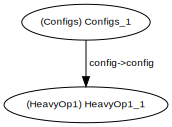

In [9]:
p.show()

In [10]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [11]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='7003bde0-d7ca-11ea-bc65-ff90592416b5', pipeline_name='heavy_op1', pipeline_run_id='c7e1854c-fdb7-4362-8247-0a66179dd1bb', pipeline_version=None, comment=None, created_on='2020-08-06T09:51:46.945+0000', start_time=None, end_time=None, eta=0, run_at=1596707506945, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='c7e1854c-fdb7-4362-8247-0a66179dd1bb', pipeline_name='heavy_op1', pipeline_status='IN_PROGRESS', block_id='24a53e33-c255-4f31-bb41-5a409264ffdc', block_run_id='24f929d6-3f09-44af-8376-eb966295329d', block_name='Configs_1', resource_spec=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='24a53e33-c255-4f31-bb41-5a409264ffdc', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-06T09:51:47.000+0000'), PlatformPipelineBlockRun(pipeline_run_id='c7e1854c-fdb7-4362-8247-0a66179dd1bb', pipeline_name='heavy_op1', pipeline_status='IN_PROGRESS', block_id='15f144a9-9a32-4531-9756-4b6c8d1513d9', block_run_id='50eafbcb-0ada-4c80-b031-281746c0a3dd', block_name='HeavyOp1_1', resource_spec=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='15f144a9-9a32-4531-9756-4b6c8d1513d9', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=35, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='24a53e33-c255-4f31-bb41-5a409264ffdc', block_run_id='24f929d6-3f09-44af-8376-eb966295329d', block_name='Configs_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-06T09:51:46.989+0000', queued_at='2020-08-06T09:51:47.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='21373b50-aba5-49ae-9d71-ac6d79119156', output_name='config', created_on='2020-08-06T09:51:46.989+0000', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON')), BlockRunDetail(block_id='15f144a9-9a32-4531-9756-4b6c8d1513d9', block_run_id='50eafbcb-0ada-4c80-b031-281746c0a3dd', block_name='HeavyOp1_1', technology='PYTHON', log_path=None, input_parameters=None, output_parameters=None, status='YET_TO_START', created_at='2020-08-06T09:51:47.015+0000', queued_at=None, start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=8192, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "7003bde0-d7ca-11ea-bc65-ff90592416b5",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "heavy_op1",\n  "description": "",\n  "blocks": [\n    {\n      "name": "HeavyOp1_1",\n      "id": "15f144a9-9a32-4531-9756-4b6c8d1513d9",\n      "artifact_id": null,\n      "class_name": "HeavyOp1",\n      "code": "eJxtVFtPG0cU3l2v7fWFSykNTaVWKOkDkYobIIFSoSrUJm1qxakAqU/RaLwze8HrmWV3BkK1riqhqEKaPnX6Dv+q/6Y9szYlD6xkz5lzzpz7d353/96vWeWnVvyES5LG/iihnQ9orR6ijEYXJMOConxEEyo4Q36C81z/pdciSy2jMR7dJ1PeUMaJiFmulSsuUgpM5f1I8dnFm3RDq08z/CvPOj7PaGeYcH+Uzw6tqt8bAvTf64lWdYQI9xHSg1ytfrNDnu8EG/4zPwie7W49HT7d3d7cDnbwxmbg72z5eiD0IbxaU02ExpzIhMJL5cEFx8yQlUwyDYHPoyBOEhRI5ouYs1k6C3fplCJgA3cOzXJB/yfS5YQem8t78LfWr/Stfrtf63e7/xCbWIk1qZSnPXEL68S5rhDnxratonLtFvaNPanOuJWS615XiqncIe5Da1KDs

In [12]:
# deployed_pipeline.run_status()

In [13]:
# # Remove some temoprary DFs
# del temp_df, add_grid

# # We will not need original train_df
# # anymore and can remove it
# del train_df

In [6]:
@inputs.atomic.string('grid_df_path')
@inputs.atomic.string('add_grid_path')
@inputs.atomic.generic('config')
class HeavyOp2(Block):
    def run(self, grid_df_path, add_grid_path, config):
        
        def sizeof_fmt(num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)
        
        
        grid_df = pd.read_csv(grid_df_path)
        add_grid = pd.read_csv(add_grid_path)

        grid_df = pd.concat([grid_df,add_grid])
        grid_df = grid_df.reset_index(drop=True)


        # Let's check our memory usage
        self.logger.info("{:>20}: {:>8}".format('Original grid_df', sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        # We can free some memory 
        # by converting "strings" to categorical
        # it will not affect merging and 
        # we will not lose any valuable data
        index_columns = config['index_columns']
        for col in index_columns:
            grid_df[col] = grid_df[col].astype('category')

        # Let's check again memory usage
        self.logger.info("{:>20}: {:>8}".format('Reduced grid_df', sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df.to_csv(project_space_path('M5Forecasting/grid_df_int.csv'))


In [7]:
heavy_op2 = (
    HeavyOp2()
    .config(configs.config)  # (series, string)
    .add_grid_path('M5Forecasting/add_grid.csv', adapter=project_space_path)  # (series, string)
    .grid_df_path('M5Forecasting/grid_df.csv', adapter=project_space_path)  # (series, string)
    .executor(ContainerExecutor(cores=2, memory=13000))
)

In [8]:
p = Pipeline("heavy_op2", targets=[heavy_op2], env=Technology.PYTHON)  #preprocess


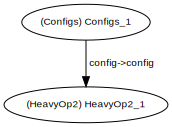

In [9]:
p.show()

In [10]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [11]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='c0f9dac4-d7d2-11ea-ac4f-b3f45cf275d7', pipeline_name='heavy_op2', pipeline_run_id='9d8c20fd-f2e3-4b91-8e81-e77327b59e8c', pipeline_version=None, comment=None, created_on='2020-08-06T10:51:18.075+0000', start_time=None, end_time=None, eta=0, run_at=1596711078075, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='9d8c20fd-f2e3-4b91-8e81-e77327b59e8c', pipeline_name='heavy_op2', pipeline_status='IN_PROGRESS', block_id='4506d3f7-5b9c-4099-aba3-ce8ae200e43d', block_run_id='cd721462-663b-4e07-ad7b-1c32af4731b0', block_name='Configs_1', resource_spec=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='4506d3f7-5b9c-4099-aba3-ce8ae200e43d', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-06T10:51:18.000+0000'), PlatformPipelineBlockRun(pipeline_run_id='9d8c20fd-f2e3-4b91-8e81-e77327b59e8c', pipeline_name='heavy_op2', pipeline_status='IN_PROGRESS', block_id='e5e3e8de-9c7f-4c65-b2cf-a88160bce5e7', block_run_id='7bd0687b-15dc-4b03-a8a9-a3892b0e503d', block_name='HeavyOp2_1', resource_spec=ResourceAllocated(cores=2, memory=13000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='e5e3e8de-9c7f-4c65-b2cf-a88160bce5e7', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=42, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='4506d3f7-5b9c-4099-aba3-ce8ae200e43d', block_run_id='cd721462-663b-4e07-ad7b-1c32af4731b0', block_name='Configs_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-06T10:51:18.103+0000', queued_at='2020-08-06T10:51:18.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='11a8ff10-01a7-420c-b117-baabeb523a52', output_name='config', created_on='2020-08-06T10:51:18.104+0000', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON')), BlockRunDetail(block_id='e5e3e8de-9c7f-4c65-b2cf-a88160bce5e7', block_run_id='7bd0687b-15dc-4b03-a8a9-a3892b0e503d', block_name='HeavyOp2_1', technology='PYTHON', log_path=None, input_parameters=None, output_parameters=None, status='YET_TO_START', created_at='2020-08-06T10:51:18.126+0000', queued_at=None, start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=13000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "c0f9dac4-d7d2-11ea-ac4f-b3f45cf275d7",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "heavy_op2",\n  "description": "",\n  "blocks": [\n    {\n      "name": "HeavyOp2_1",\n      "id": "e5e3e8de-9c7f-4c65-b2cf-a88160bce5e7",\n      "artifact_id": null,\n      "class_name": "HeavyOp2",\n      "code": "eJx1VG1vE0cQvndfnARQBaF8IIoQqYzUuCYlJCAUFUJLW4uAEiBqJbRa3+75Lj7fXm53aUJtiQpSirRIlbr9nvyN/qP+inb27LxUSh1lb2bnfXbmeeP9+XdgVT91OcqYJEUa9TLaPEVrdQWVNNkjJRYU8R7NqGA5ijLMuf5DNxJLXUR93DtLpsKOTDOR5lwrT+wVFC5V+C3Fr/aeFItafVri16xsRqykzU7Goh4ff7TyHxgC9Pf1UKsaQoRFCOl1ruZuLrVad1qdOFqKW7cWO3fw8gppxbeWWytk8Q6I9LrQG2DVUHWE+ozIjIKlCoHBaW5It5S5hsTPoTjNMhTLPBIpy8flnD8ppxLBNdxOo3Et6LiQNUboM8PsQ7xG22tb7Qn4W1v7i0wTh7jv7KEnrAN7YB/aQ7+iHKACoJyBPwi6hvMH/rZLPOJ/NLS17R34JDg

In [12]:
@inputs.atomic.string('grid_df_path')
@inputs.atomic.generic('config')
class HeavyOp3(Block):
    def run(self, grid_df_path, config):
        from razor.api import project_space_path
        
        def sizeof_fmt(num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)

        self.logger.info('Release week')
        
        def merge_by_concat(df1, df2, merge_on):
            merged_gf = df1[merge_on]
            merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
            new_columns = [col for col in list(merged_gf) if col not in merge_on]
            df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
            return df1

        
        prices_df = pd.read_csv(project_space_path(config['prices_path']))
        grid_df = pd.read_csv(grid_df_path)
        calendar_df = pd.read_csv(project_space_path(config['calendar_path']))
        # Prices are set by week
        # so it we will have not very accurate release week 
        release_df = prices_df.groupby(['store_id','item_id'])['wm_yr_wk'].agg(['min']).reset_index()
        release_df.columns = ['store_id','item_id','release']
        self.logger.info('Release Df')
        self.logger.info(release_df.head())
        
        # Now we can merge release_df
        grid_df = merge_by_concat(grid_df, release_df, ['store_id','item_id'])
        del release_df


        grid_df = merge_by_concat(grid_df, calendar_df[['wm_yr_wk','d']], ['d'])

        # Now we can cutoff some rows 
        # and safe memory 
        grid_df = grid_df[grid_df['wm_yr_wk']>=grid_df['release']]
        grid_df = grid_df.reset_index(drop=True)

        # Let's check our memory usage
        self.logger.info("{:>20}: {:>8}".format('Original grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df['release'] = grid_df['release'] - grid_df['release'].min()
        grid_df['release'] = grid_df['release'].astype(np.int16)

        # Let's check again memory usage
        self.logger.info("{:>20}: {:>8}".format('Reduced grid_df',sizeof_fmt(grid_df.memory_usage(index=True).sum())))

        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl'))
        grid_df.to_csv(project_space_path('M5Forecasting/grid_df_final.pkl'))
                       
                       

In [13]:
heavy_op3 = (
    HeavyOp3()
    .config(configs.config)  # (series, generic)
    .grid_df_path('M5Forecasting/grid_df_int.csv', adapter=project_space_path)  # (series, string)
    .executor(ContainerExecutor(cores=2, memory=20000))
)

In [14]:
p = Pipeline("heavy_op3", targets=[heavy_op3], env=Technology.PYTHON)  #preprocess


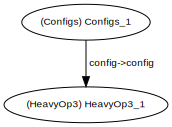

In [15]:
p.show()

In [16]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [17]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='9eb65358-d86c-11ea-ad86-431d80c6c5a4', pipeline_name='heavy_op3', pipeline_run_id='60a89c90-3231-4759-ab1f-b184c79339cb', pipeline_version=None, comment=None, created_on='2020-08-07T05:12:45.656+0000', start_time=None, end_time=None, eta=0, run_at=1596777165656, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='60a89c90-3231-4759-ab1f-b184c79339cb', pipeline_name='heavy_op3', pipeline_status='IN_PROGRESS', block_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', block_run_id='5ba418f5-417b-4849-8b0c-8abc8a3f47e1', block_name='Configs_1', resource_spec=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-07T05:12:46.000+0000'), PlatformPipelineBlockRun(pipeline_run_id='60a89c90-3231-4759-ab1f-b184c79339cb', pipeline_name='heavy_op3', pipeline_status='IN_PROGRESS', block_id='e58d3952-36e3-4b08-a7e6-ed53e5d24da6', block_run_id='6afe5e7f-df31-42e3-b3fe-6b6aec570efc', block_name='HeavyOp3_1', resource_spec=ResourceAllocated(cores=2, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='e58d3952-36e3-4b08-a7e6-ed53e5d24da6', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=48, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', block_run_id='5ba418f5-417b-4849-8b0c-8abc8a3f47e1', block_name='Configs_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-07T05:12:45.690+0000', queued_at='2020-08-07T05:12:46.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='e35e699a-13bc-4cba-b56c-0fdf521db489', output_name='config', created_on='2020-08-07T05:12:45.691+0000', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON')), BlockRunDetail(block_id='e58d3952-36e3-4b08-a7e6-ed53e5d24da6', block_run_id='6afe5e7f-df31-42e3-b3fe-6b6aec570efc', block_name='HeavyOp3_1', technology='PYTHON', log_path=None, input_parameters=None, output_parameters=None, status='YET_TO_START', created_at='2020-08-07T05:12:45.704+0000', queued_at=None, start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=2, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "9eb65358-d86c-11ea-ad86-431d80c6c5a4",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "heavy_op3",\n  "description": "",\n  "blocks": [\n    {\n      "name": "HeavyOp3_1",\n      "id": "e58d3952-36e3-4b08-a7e6-ed53e5d24da6",\n      "artifact_id": null,\n      "class_name": "HeavyOp3",\n      "code": "eJyNFm1v28b5jqQkSpZt1XEce0BbY4gHe5hV25kztwiMNu5bKtQd4gLDNgQHind8sfgW8hhHGVUUc9I4wAVo0eunfpE/dd83oNvP2S/ZniMl2xtSoCL08O55uef9Hn5pfPfvJip/4oYdxDlNfHsQsO6VtRQrJGXekKYWZyQbsIDxOCJ2YGWZ/Faue0gsktAavIomzH7uB9yPMikMPkwYIIX5MbMeDT9LbkmxnFpP4rRrxynr9oPYHmSTlxS1u2oB/M/kSIoGITS2CZGHmVh1dpzdnVv9LbbrOL/dc3b7e9Zturv9Nt3btbecWzvykMv7ILUuWoSEMc0DBpLChI3lR2qpp3kkwfA54vhBQJw8srkfRxN35i/dKUmABuwsmfhCLhw5iCn7XG2egb71nt5DvVav2Tu4+wQjRDHVAhTikY4R/QU1aO0pHhkFOtbGOq2fY8A

In [42]:
# @inputs.atomic.string('prices_df_path')
# @inputs.atomic.string('calendar_df_path')
@inputs.atomic.string('grid_path')
@inputs.atomic.generic('config')
class HeavyOp4(Block):
    def run(self, grid_path, config):
        from razor.api import project_space_path
        
        def sizeof_fmt(num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)

        self.logger.info('Release week')
        
        def merge_by_concat(df1, df2, merge_on):
            merged_gf = df1[merge_on]
            merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
            new_columns = [col for col in list(merged_gf) if col not in merge_on]
            df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
            return df1
        
        def reduce_mem_usage(df, verbose=True):
            numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
            start_mem = df.memory_usage().sum() / 1024**2    
            for col in df.columns:
                col_type = df[col].dtypes
                if col_type in numerics:
                    c_min = df[col].min()
                    c_max = df[col].max()
                    if str(col_type)[:3] == 'int':
                        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                            df[col] = df[col].astype(np.int8)
                        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                               df[col] = df[col].astype(np.int16)
                        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                            df[col] = df[col].astype(np.int32)
                        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                            df[col] = df[col].astype(np.int64)  
                    else:
                        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                            df[col] = df[col].astype(np.float16)
                        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                            df[col] = df[col].astype(np.float32)
                        else:
                            df[col] = df[col].astype(np.float64)    
            end_mem = df.memory_usage().sum() / 1024**2
            
            if verbose: 
                print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
            
            return df

        prices_df=pd.read_csv(project_space_path(config["prices_path"]))
        calendar_df=pd.read_csv(project_space_path(config["calendar_path"]))
        
        self.logger.info('Prices')

        # We can do some basic aggregations
        prices_df['price_max'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('max')
        prices_df['price_min'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('min')
        prices_df['price_std'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('std')
        prices_df['price_mean'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('mean')

        # and do price normalization (min/max scaling)
        prices_df['price_norm'] = prices_df['sell_price']/prices_df['price_max']

        # Some items are can be inflation dependent
        # and some items are very "stable"
        prices_df['price_nunique'] = prices_df.groupby(['store_id','item_id'])['sell_price'].transform('nunique')
        prices_df['item_nunique'] = prices_df.groupby(['store_id','sell_price'])['item_id'].transform('nunique')

        # I would like some "rolling" aggregations
        # but would like months and years as "window"
        calendar_prices = calendar_df[['wm_yr_wk','month','year']]
        calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
        prices_df = prices_df.merge(calendar_prices[['wm_yr_wk','month','year']], on=['wm_yr_wk'], how='left')
        del calendar_prices

        # Now we can add price "momentum" (some sort of)
        # Shifted by week 
        # by month mean
        # by year mean
        prices_df['price_momentum'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id'])['sell_price'].transform(lambda x: x.shift(1))
        prices_df['price_momentum_m'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','month'])['sell_price'].transform('mean')
        prices_df['price_momentum_y'] = prices_df['sell_price']/prices_df.groupby(['store_id','item_id','year'])['sell_price'].transform('mean')

        del prices_df['month'], prices_df['year']
        
        ########################## Merge prices and save part 2
        #################################################################################
        self.logger.info('Merge prices and save part 2')

        grid_df = pd.read_pickle(grid_path)
        MAIN_INDEX=config["MAIN_INDEX"]
        
        # Merge Prices
        original_columns = list(grid_df)
        grid_df = grid_df.merge(prices_df, on=['store_id','item_id','wm_yr_wk'], how='left')
        keep_columns = [col for col in list(grid_df) if col not in original_columns]
        grid_df = grid_df[MAIN_INDEX+keep_columns]
        grid_df = reduce_mem_usage(grid_df)

        # Safe part 2
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_2.pkl'))
        self.logger.info('Size:', grid_df.shape)

        

In [43]:
heavy_op4 = (
    HeavyOp4()
    .config(configs.config)  # (series, generic)
    .grid_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl', adapter=project_space_path)  # (series, string)
    .executor(ContainerExecutor(cores=3, memory=20000))
)

In [44]:
p = Pipeline("heavy_op4", targets=[heavy_op4], env=Technology.PYTHON)  #preprocess


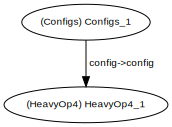

In [45]:
p.show()

In [46]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [47]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='ce705726-d874-11ea-ad86-431d80c6c5a4', pipeline_name='heavy_op4', pipeline_run_id='67782285-2522-4cef-80fc-498d26ff6857', pipeline_version=None, comment=None, created_on='2020-08-07T06:11:18.977+0000', start_time=None, end_time=None, eta=0, run_at=1596780678977, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='67782285-2522-4cef-80fc-498d26ff6857', pipeline_name='heavy_op4', pipeline_status='IN_PROGRESS', block_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', block_run_id='bbc321b6-d96d-4ba3-aa8d-b9c26eef0e85', block_name='Configs_1', resource_spec=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-07T06:11:19.000+0000'), PlatformPipelineBlockRun(pipeline_run_id='67782285-2522-4cef-80fc-498d26ff6857', pipeline_name='heavy_op4', pipeline_status='IN_PROGRESS', block_id='e1d96a27-b97b-4758-a5fe-03d5d56db5b1', block_run_id='d578a81e-b627-453e-94f3-48538e8315b3', block_name='HeavyOp4_1', resource_spec=ResourceAllocated(cores=3, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='e1d96a27-b97b-4758-a5fe-03d5d56db5b1', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=53, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', block_run_id='bbc321b6-d96d-4ba3-aa8d-b9c26eef0e85', block_name='Configs_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-07T06:11:19.017+0000', queued_at='2020-08-07T06:11:19.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='9f7b7393-17c7-4dd7-ba17-7ad059f17118', output_name='config', created_on='2020-08-07T06:11:19.018+0000', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON')), BlockRunDetail(block_id='e1d96a27-b97b-4758-a5fe-03d5d56db5b1', block_run_id='d578a81e-b627-453e-94f3-48538e8315b3', block_name='HeavyOp4_1', technology='PYTHON', log_path=None, input_parameters=None, output_parameters=None, status='YET_TO_START', created_at='2020-08-07T06:11:19.031+0000', queued_at=None, start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=3, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "ce705726-d874-11ea-ad86-431d80c6c5a4",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "heavy_op4",\n  "description": "",\n  "blocks": [\n    {\n      "name": "HeavyOp4_1",\n      "id": "e1d96a27-b97b-4758-a5fe-03d5d56db5b1",\n      "artifact_id": null,\n      "class_name": "HeavyOp4",\n      "code": "eJyVV91vFMkRn56Z3Z39sL0YMDhwsCHYsUm8gAFjkEMODOG4lZ0LPuXyITSZne7ZHu/szHo+sM3NRpGAA6RG4pTJ68l+PekeTsqfEOnuMX8Aj/eQvN1DIiV5Sap7Ztd7x0ZKvHJPd1X9uqq7uqq6f6f+4W5VEn/smOl4Ee7aZtsh9aF+wqZ1n9Bd7Bsh0YM2cUjoubrpGEGQ/D6ZoxI7oneM9ige05qR7YS2GyRMDXe7BIhMe4cYD3d/2r2csOO+8cjz66bnk3rT8cx2kH0SlrvFOyD/NOklrKDr2DN1PVkPWM1qksvLZPHi0hVMLmNzefna1UsXlhcvX7q4hBeXjKVkPUzuA2qOlXS94+HIIYBkGgwM2+VdxY/cBAwf1y3bcXQrcs3Q9txsORMHyxEsIAN1TM/Wog8Wsuph8j4fPAV9cw2lITXGGvmGcqspSxJGWHa

In [53]:
# @inputs.atomic.string('prices_df_path')
# @inputs.atomic.string('calendar_df_path')
@inputs.atomic.string('grid_path')
@inputs.atomic.generic('config')
class HeavyOp5(Block):
    def run(self, grid_path, config):
        from razor.api import project_space_path
        
        def sizeof_fmt(num, suffix='B'):
            for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
                if abs(num) < 1024.0:
                    return "%3.1f%s%s" % (num, unit, suffix)
                num /= 1024.0
            return "%.1f%s%s" % (num, 'Yi', suffix)

        self.logger.info('Release week')
        
        def merge_by_concat(df1, df2, merge_on):
            merged_gf = df1[merge_on]
            merged_gf = merged_gf.merge(df2, on=merge_on, how='left')
            new_columns = [col for col in list(merged_gf) if col not in merge_on]
            df1 = pd.concat([df1, merged_gf[new_columns]], axis=1)
            return df1

        
        calendar_df=pd.read_csv(project_space_path(config["calendar_path"]))
        grid_df = pd.read_pickle(grid_path)
        MAIN_INDEX=config["MAIN_INDEX"]
        
        ########################### Merge calendar
        #################################################################################
        grid_df = grid_df[MAIN_INDEX]

        # Merge calendar partly
        icols = ['date',
                 'd',
                 'event_name_1',
                 'event_type_1',
                 'event_name_2',
                 'event_type_2',
                 'snap_CA',
                 'snap_TX',
                 'snap_WI']

        grid_df = grid_df.merge(calendar_df[icols], on=['d'], how='left')

        # Minify data
        # 'snap_' columns we can convert to bool or int8
        icols = ['event_name_1',
                 'event_type_1',
                 'event_name_2',
                 'event_type_2',
                 'snap_CA',
                 'snap_TX',
                 'snap_WI']
        for col in icols:
            grid_df[col] = grid_df[col].astype('category')

        # Convert to DateTime
        grid_df['date'] = pd.to_datetime(grid_df['date'])

        # Make some features from date
        grid_df['tm_d'] = grid_df['date'].dt.day.astype(np.int8)
        grid_df['tm_w'] = grid_df['date'].dt.week.astype(np.int8)
        grid_df['tm_m'] = grid_df['date'].dt.month.astype(np.int8)
        grid_df['tm_y'] = grid_df['date'].dt.year
        grid_df['tm_y'] = (grid_df['tm_y'] - grid_df['tm_y'].min()).astype(np.int8)
        grid_df['tm_wm'] = grid_df['tm_d'].apply(lambda x: ceil(x/7)).astype(np.int8)

        grid_df['tm_dw'] = grid_df['date'].dt.dayofweek.astype(np.int8)
        grid_df['tm_w_end'] = (grid_df['tm_dw']>=5).astype(np.int8)

        # Remove date
        del grid_df['date']
        ########################### Save part 3 (Dates)
        #################################################################################
        print('Save part 3')

        # Safe part 3
        grid_df.to_pickle(project_space_path('M5Forecasting/m5-simple-fe/grid_part_3.pkl'))
        print('Size:', grid_df.shape)

        # We don't need calendar_df anymore
        del calendar_df
        del grid_df



In [54]:
heavy_op5 = (
    HeavyOp5()
    .config(configs.config)  # (series, generic)
    .grid_path('M5Forecasting/m5-simple-fe/grid_part_1.pkl', adapter=project_space_path)  # (series, string)
    .executor(ContainerExecutor(cores=3, memory=20000))
)

In [55]:
p = Pipeline("heavy_op5", targets=[heavy_op5], env=Technology.PYTHON)  #preprocess


In [56]:
deployed_pipeline = razor.api.engines('DS-engine').execute(pipeline=p)


In [57]:
deployed_pipeline

PlatformPipelineRun(project_id='c0b26d85-a4c9-44f5-9d0e-f540dd2de644', pipeline_id='55711658-d879-11ea-ad86-431d80c6c5a4', pipeline_name='heavy_op5', pipeline_run_id='f28118d6-f6cf-45ea-b7d8-7f07e2d5d3a7', pipeline_version=None, comment=None, created_on='2020-08-07T06:43:43.036+0000', start_time=None, end_time=None, eta=0, run_at=1596782623036, run_duration=0, compute_time=0, wait_time=0, ran_by_user=RanByUser(user_name='Ayan Basak', email='ayan.basak@razorthink.com'), status='IN_PROGRESS', block_status=[PlatformPipelineBlockRun(pipeline_run_id='f28118d6-f6cf-45ea-b7d8-7f07e2d5d3a7', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', block_run_id='809c25b6-a44b-4b8f-ac62-f99e3acecaaa', block_name='Configs_1', resource_spec=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='READY_TO_GO', containers=[], cluster_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at='2020-08-07T06:43:43.000+0000'), PlatformPipelineBlockRun(pipeline_run_id='f28118d6-f6cf-45ea-b7d8-7f07e2d5d3a7', pipeline_name='heavy_op5', pipeline_status='IN_PROGRESS', block_id='c9a23287-6732-4163-aecd-d7008b306a5f', block_run_id='df3a2817-11d7-48f1-b977-487d0d67dc2a', block_name='HeavyOp5_1', resource_spec=ResourceAllocated(cores=3, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'), technology='PYTHON', status='YET_TO_START', containers=[], cluster_id='c9a23287-6732-4163-aecd-d7008b306a5f', _log=None, _metric=None, wait_time=0, compute_time=0, start_time=None, end_time=None, queued_at=None)], run_number=55, pipeline_variable_list=[], block_run_details=[BlockRunDetail(block_id='1312f5ec-9662-41a7-bf21-176bd2a676e9', block_run_id='809c25b6-a44b-4b8f-ac62-f99e3acecaaa', block_name='Configs_1', technology='PYTHON', log_path=None, input_parameters='{}', output_parameters=None, status='READY_TO_GO', created_at='2020-08-07T06:43:43.083+0000', queued_at='2020-08-07T06:43:43.000+0000', start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[BlockRunOutputList(output_id='66e919a4-3d6a-4756-8496-62a77d4e6371', output_name='config', created_on='2020-08-07T06:43:43.084+0000', output_status='YET_TO_START', block_transport='FILE')], resource_allocated=ResourceAllocated(cores=1, memory=1024, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON')), BlockRunDetail(block_id='c9a23287-6732-4163-aecd-d7008b306a5f', block_run_id='df3a2817-11d7-48f1-b977-487d0d67dc2a', block_name='HeavyOp5_1', technology='PYTHON', log_path=None, input_parameters=None, output_parameters=None, status='YET_TO_START', created_at='2020-08-07T06:43:43.105+0000', queued_at=None, start_time=None, end_time=None, compute_time=0, wait_time=0, run_time=0, block_run_output_list=[], resource_allocated=ResourceAllocated(cores=3, memory=20000, use_gpu=False, gpu=0, use_gpu_if_available=False, additional_resource_spec={}, run_env='PYTHON'))], pipeline_json='{\n  "id": "55711658-d879-11ea-ad86-431d80c6c5a4",\n  "projectId": "c0b26d85-a4c9-44f5-9d0e-f540dd2de644",\n  "name": "heavy_op5",\n  "description": "",\n  "blocks": [\n    {\n      "name": "HeavyOp5_1",\n      "id": "c9a23287-6732-4163-aecd-d7008b306a5f",\n      "artifact_id": null,\n      "class_name": "HeavyOp5",\n      "code": "eJyNFttuG8d19kJySdGyIlu0lDSKmlqFVECMJUWRXKhubNpNVMJMYhlw2sIYDHdmuSvuTbuzkhgsgwKy4wSYFCk6fWnyIP9BPyB9b4G239A/ac8sKZkO/FAuOJcz536ZOb83//yfGip+4prtRxmNPbvvs+bEWooFnDB3QBPCGU77zGc8CrHtkzSVf5IrLhJXcUD6rzoTVjfzfO6FqRQmH8QMgML6kJGjwUfxlhTzCfksSpp2lLBm14/sfjqepCjdUQvAfyqHUlQwppGNseykYmmbbNgbN7e3unTjxrvbXXKzu7m+tbPF3tt511l/z9mWHS4fANWKqGEcRDTzGVAKCzbEC9XSSLJQguLT2PF8HztZaHMvCsfmXH5hTnEEYIBewmNb8IUhrYiyh2rzFOSttI02ak+1q+3Wne81hKhGdR8F2tDQEL1OTVp6og3NHB3oZwY